# Guide to Extracting Data w/ APIs from Strava


<img src='https://i.imgur.com/jneRMpU.jpg' height="500"> 

A picture of the Strava Mobile Application







Strava is often regarded as the “social network for athletes.” It lets you track your running and riding with GPS, join Challenges, share photos from your activities, and follow friends. <br>

Strava follows a fremium model offering a digital service accessible through its mobile applications (iOS and Android). Users also have an option to upgrade and unlock more advanced features like Custom Goals, Training Plans, Race Analysis, etc for a monthly fee of $5-8. <br>

We've been using the strava application for the past few weeks and we will show you how to extract its data, visualize your runs and compute correlations between multiple metrics of the data. The Strava API allows the users to extract all sorts of data on athletes, segments, routes, clubs, and gear. However, for this notebook we will be focusing on metrics of the participant's activities like dates, speed, elevation, duration, etc.



We will be able to extract the following parameters:

Parameter Name  | Sampling Frequency 
-------------------|-----------------
Moving Time |  Per Activity 
Elapsed Time |  Per Activity 
Average Speed |  Per Activity 
Maximum Speed |  Per Activity 
Average Cadence |  Per Activity
Maximum Cadence |  Per Activity
Average Watts |  Per Activity
Maximum Watts |  Per Activity
Average Heart Rate |  Per Activity
Maximum Heartrate |  Per Activity
Distance      |  Records every change in user's position
Polyline Summary |  Records every change in user's position
Total Elevation Gain |  Sampling Frequency depends upon user's fitness tracker
Heart Rate  | Sampling Frequency depends upon user's fitness tracker

In this guide, we sequentially cover the following **five** topics to extract data from the Strava API:

1. **Set up**<br>
   - 1.1 Setup and usage guidelines for the participant. <br>
   - 1.2 Library imports <br>
2. **Authentication/Authorization**<br>
   - 2.1 Usage and Authentication guidelines for the researcher.<br>
3. **Data extraction**<br>
  - 3.1 Extracting Data from the Strava API<br>
4. **Data visualization & analysis** <br>
  - 4.1 Visualizing participant's Overall Activity! <br>
  - 4.2 Visualizing participant's Weekly Summary! <br>
  - 4.3 Visualizing Participant's Runs! <br>
5. **Data Analysis** <br>
  - 5.1 Analyzing correlation between Participant's data! <br>
  - 5.2 Highlighting Outliers!

Note that we are not making any scientific claims here as our sample size is small and the data collection process was not rigorously vetted (it is our own data), only demonstrating that this code could potentially be used to perform rigorous analyses in the future.


#1. Set up

##1.1 Setup and usage, participant

Note: These steps are to be followed by the participants from their account to grant the researcher with the access token.

Step 1: Make sure that the your coros watch is connected to your strava account. Next, go to https://developers.strava.com/ 

Step 2: Click on "Create and Manage your App"

<img src='https://i.imgur.com/nBdQDR6.png' width="850" height="500">


Step 3: Strava will prompt you to login. Make sure to login with the account that participants have been using to record their runs

Step 4: Fill out your details:<br>
Here's an example with some dummy information! <br>
<img src='https://i.imgur.com/O9jRXQQ.png' width="450" height="400">


Step 5: Next, Strava will ask you to upload a app icon. I personally uploaded the Strava logo in the option. <br>
<img src='https://i.imgur.com/wQHGyL2.png' width="600" height="400"> <br> Copy and crop the Image to your preference and hit save! <br>
<img src='https://i.imgur.com/kKodoZm.png' width="600" height="400">


Step 6: You're done! <br>
<img src='https://i.imgur.com/Svm3FV8.png' width="600" height="400"> <br>
Copy and paste your your client ID, Client Token and Refresh token in the box below and give it to the researcher.



## 1.2 Library imports

Relevant libraries are imported below. Just run the code to import all the libraries.

In [ ]:
### Note: if the cell below says that polyline is missing then uncomment the line below and run it!
!pip install polyline

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import requests
import urllib3
import os
import json
import httplib2
import requests
import datetime
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pandas as pd
from datetime import datetime
from pandas.io.json import json_normalize
import time
from datetime import datetime, timedelta, date
from apiclient.discovery import build
from oauth2client.client import OAuth2WebServerFlow, flow_from_clientsecrets
from oauth2client.file import Storage
import polyline
import folium
from sklearn.covariance import EllipticEnvelope
import seaborn as sns

#2. Authentication/Authorization
To obtain access to data, authorization is required.

STRAVA is used to extract recorded activities, but it requires the participant to allow third-party access to STRAVA and record activities on their device.

##2.1 Setup and usage, researcher

In [ ]:
#@title Enter paricipant's Client ID, Client Secret and Refresh Token

client_id = '83434' #@param {type:"string"}
client_secret = '915c245ef1949c64e9a1e01dfa7a52f78bc4628c' #@param {type:"string"}
refresh_token = '7c7c2b4ff166f43e7a0d7329a60c379419623766' #@param {type:"string"}

print('Client ID: '+client_id)
print('Client Secret: '+client_secret)
print('Refresh Token: '+refresh_token)

Client ID: 83434
Client Secret: 915c245ef1949c64e9a1e01dfa7a52f78bc4628c
Refresh Token: 7c7c2b4ff166f43e7a0d7329a60c379419623766


#3. Data extraction

Strava's data can be extracted via an [official API](https://developers.strava.com/), which is documented [here](https://developers.strava.com/docs/reference/).<br><br>

We will go into a bit of detail as to how this works below. This is not strictly necessary for extracting your data once, but it can be necessary if you want to extend this notebook for your own usage. <br><br>

Below, the first figure shows how data is uploaded to Strava servers. Strava offers three ways to record an activity: <br>
1) Entering data manually <br>
2) Recording your run with the Strava app using your phone's GPS location. <br> 
3) Syncing the data recorded by a fitness tracker, likely a GPS-based smartwatch<br><br>

As your phone is synced with Strava, your data gets automatically pushed on to Strava's servers. <br><br>

<img src="https://i.imgur.com/Ve5xs2i.png" height="500">

The next few lines create a post request to the Strava API and requests your data

In [ ]:
urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)

# The auth_url specifies the URL to the endpoint that authenticates user credentials
auth_url = "https://www.strava.com/oauth/token"
# URL to access all of participant's activities.
activites_url = "https://www.strava.com/api/v3/athlete/activities"

#payload sends the user's credentials to the API during POST request
payload = {
    'client_id': client_id,
    'client_secret': client_secret,
    'refresh_token': refresh_token,
    'grant_type': "refresh_token",
    'f': 'json'
}

print("Requesting Token...\n")
#POST request to get the participant's ACCESS TOKEN
res = requests.post(auth_url, data=payload, verify=False)
# saving the participant's ACCESS TOKEN
access_token = res.json()['access_token']
print("Access Token = {}\n".format(access_token))

#Header that sends the Access Token in the GET request
header = {'Authorization': 'Bearer ' + access_token}
param = {'per_page': 200, 'page': 1}
#GET request to get all your activities from the API
my_dataset = requests.get(activites_url, headers=header, params=param).json()

Requesting Token...

Access Token = 9ad3c5dd8ec6bbde877008818b1d20890f268bbf



In [ ]:
my_dataset

[{'resource_state': 2,
  'athlete': {'id': 102185603, 'resource_state': 1},
  'name': 'Lunch Ride',
  'distance': 0.0,
  'moving_time': 185,
  'elapsed_time': 185,
  'total_elevation_gain': 0,
  'type': 'Ride',
  'sport_type': 'Ride',
  'workout_type': None,
  'id': 8228598438,
  'start_date': '2022-12-09T19:24:04Z',
  'start_date_local': '2022-12-09T11:24:04Z',
  'timezone': '(GMT-08:00) PST8PDT',
  'utc_offset': -28800.0,
  'location_city': None,
  'location_state': None,
  'location_country': None,
  'achievement_count': 0,
  'kudos_count': 0,
  'comment_count': 0,
  'athlete_count': 1,
  'photo_count': 0,
  'map': {'id': 'a8228598438', 'summary_polyline': '', 'resource_state': 2},
  'trainer': True,
  'commute': False,
  'manual': False,
  'private': False,
  'visibility': 'everyone',
  'flagged': False,
  'gear_id': None,
  'start_latlng': [],
  'end_latlng': [],
  'average_speed': 0.0,
  'max_speed': 0.0,
  'has_heartrate': True,
  'average_heartrate': 124.5,
  'max_heartrate': 1

In [ ]:
res.json()

{'token_type': 'Bearer',
 'access_token': '9ad3c5dd8ec6bbde877008818b1d20890f268bbf',
 'expires_at': 1671097583,
 'expires_in': 6462,
 'refresh_token': '7c7c2b4ff166f43e7a0d7329a60c379419623766'}

In [ ]:
res.json()

{'token_type': 'Bearer',
 'access_token': '9ad3c5dd8ec6bbde877008818b1d20890f268bbf',
 'expires_at': 1671097583,
 'expires_in': 6462,
 'refresh_token': '7c7c2b4ff166f43e7a0d7329a60c379419623766'}

As you can see above, my_dataset is not in a human readable format. in order to make it readable and for easy manipulation, we will normalize the results from the API call and store all the information into a pandas Data Frame

In [ ]:
str#Normalizes our fetched data from JSON to a pandas DataFrame
df_strava = pd.json_normalize(my_dataset)

Below, let's plot our DataFrame to see how it compares to the json call from our API!

In [ ]:
df_strava

,resource_state,name,distance,moving_time,elapsed_time,total_elevation_gain,type,sport_type,workout_type,id,...,map.summary_polyline,map.resource_state,elev_high,elev_low,average_cadence,average_watts,max_watts,weighted_average_watts,kilojoules,device_watts
0,2,Lunch Ride,0.0,185,185,0.0,Ride,Ride,NaN,8228598438,...,,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,Evening Ride,261.2,117,798,0.0,Ride,Ride,NaN,7834503495,...,mnzrIuwlkABDIw@CCAVCCNZr@p@LFIDFFb@NVRGBs@QWk@...,2,12.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN
2,2,Morning Ride,7179.0,836,836,46.0,Ride,Ride,NaN,7834503507,...,urwrIkyriADxDGtB[zEM|@YrA{EdOgBzEaAvCoObg@cEjN...,2,37.0,15.0,NaN,NaN,NaN,NaN,NaN,NaN
3,2,Morning Run,4530.4,1907,2450,16.0,Run,Run,NaN,7795133796,...,gklcFdtshV@HIJMFO@u@Gs@SYA{@Oq@]]_@k@K_@S[KmAO...,2,35.0,25.0,77.0,195.3,285.0,191.0,372.4,True
4,2,Afternoon Run,3647.7,1454,1468,18.0,Run,Run,NaN,7795133787,...,mtlcFrqshVq@IKGIMEAqAW_@CgASSMiAWYIe@Im@WWQ]BY...,2,37.0,19.0,77.4,198.7,306.0,211.0,288.8,True
5,2,Morning Run,4584.1,1994,2691,19.0,Run,Run,NaN,7170552790,...,ailcF|lshVFKF]AEIG[AcAUi@G]Mg@?s@[i@Au@Ye@W_@M...,2,29.0,16.0,78.4,185.7,294.0,185.0,370.2,True
6,2,Morning Run,2898.4,1252,1268,21.0,Run,Run,NaN,7154793821,...,ovlcFhrshVy@GmAWa@CUIQMQUGS?GTm@D[J]Fk@JUBQ?]I...,2,46.0,28.0,75.0,189.0,282.0,194.0,236.7,True
7,2,Afternoon Run,2747.3,1049,1246,9.0,Run,Run,NaN,7154793774,...,wilcFltshVCEGCYFW@e@QSAU@GAQG]EgBg@q@Kc@BW?m@G...,2,52.0,33.0,78.0,210.0,352.0,208.0,220.3,True
8,2,Morning Run,4472.2,1822,1835,47.0,Run,Run,NaN,7154793791,...,aflcFpzshVALPz@Rb@DFD@hAo@N@HCt@y@HGHAPBPHPh@J...,2,68.0,38.0,77.6,200.1,346.0,206.0,364.6,True
9,2,Afternoon Ride,0.0,6,6,0.0,Ride,Ride,NaN,7127406869,...,,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
df_strava.get('average_cadence')

0      NaN
1      NaN
2      NaN
3     77.0
4     77.4
5     78.4
6     75.0
7     78.0
8     77.6
9      NaN
10    73.7
11    53.9
12    77.0
13    77.3
Name: average_cadence, dtype: float64

In [ ]:
df_strava.columns

Index(['resource_state', 'name', 'distance', 'moving_time', 'elapsed_time',
       'total_elevation_gain', 'type', 'sport_type', 'workout_type', 'id',
       'start_date', 'start_date_local', 'timezone', 'utc_offset',
       'location_city', 'location_state', 'location_country',
       'achievement_count', 'kudos_count', 'comment_count', 'athlete_count',
       'photo_count', 'trainer', 'commute', 'manual', 'private', 'visibility',
       'flagged', 'gear_id', 'start_latlng', 'end_latlng', 'average_speed',
       'max_speed', 'has_heartrate', 'average_heartrate', 'max_heartrate',
       'heartrate_opt_out', 'display_hide_heartrate_option', 'upload_id',
       'upload_id_str', 'external_id', 'from_accepted_tag', 'pr_count',
       'total_photo_count', 'has_kudoed', 'athlete.id',
       'athlete.resource_state', 'map.id', 'map.summary_polyline',
       'map.resource_state', 'elev_high', 'elev_low', 'average_cadence',
       'average_watts', 'max_watts', 'weighted_average_watts', 'kilojou

As you can see, that looks much more visually appealing than our json call. Using this DataFrame we can easily do different sorts of visualizations and Analysis on this data!

#4. Data visualization

##4.1 Visualizing participant's Overall Activity!

Whenever our participant is curious and logs into Strava to check their overall summary, the Strava app would present their data in the form of a barchart. It should look something similar to this: <br>
<img src="https://i.imgur.com/cr5VYpu.png" height="300">
 <br>
<i>Above is a plot from the app! </i><br> <br>

Now that we have user's data, let's try to recreate the chart above using our python skills!


<b>Note:</b> Overall summary includes distance from all the runs, walks and rides walks recorded by the participant.

Based on the chart above, we can see that our total elevation gain is showed in feet while our data fetched from the API is in metre. So next lets convert our total elevation into feet. This step involves applying a formula to every elevation value (1 metre is numerically equal to 3.281 feet).

In [ ]:
#Converting all the elevation gains from metres to feet
elevation_df = df_strava.assign(total_elevation_gain 
  = df_strava['total_elevation_gain'].apply(lambda elevation: elevation*3.281))

Our data is not continuous, i.e. most participant do not run daily. In order to plot it correctly, we will create a dictionary of dates between the start and end date of our chart and store the elevation values.

In [ ]:
#@title Set date range for the chart above

start = "2022-04-25" #@param {type:"date"}
end = "2022-05-25" #@param {type:"date"}

In [ ]:
#Function that converts data into a date time object
datefixer = lambda date: datetime.fromisoformat(date[0:10])

#Applying datefixer function to every column of elevation_df
elevation_df = elevation_df.assign(date 
                          = elevation_df.get('start_date').apply(datefixer))

#Dictionary to store dates froms start to end date along with elevations
date_etime = {}

#Starting date of our chart
start_date = date(int(start.split('-')[0]),int(start.split('-')[1]),
                  int(start.split('-')[2]))

#Ending date of our chart
end_date = date(int(end.split('-')[0]),int(end.split('-')[1]),
                int(end.split('-')[2]))

#A list of all dates between start and end date
dates = list(pd.date_range(start_date,end_date-timedelta(days=1),freq='d'))

In [ ]:
# Storing toal distance, time and elevation
total_distance = 0
total_time = 0
total_elevation = 0

#Loop to find the elevation for each date within the Data Frame
for date_val in dates:
  #Initializes the current date in the dictionary as zero
  date_etime[str(date_val.day)+" "+str(date_val.month_name())[:3]] = 0
  for actvity_index in range(len(elevation_df)):
    #Checks if the current date is in the activity DataFrame
      if(date_val == elevation_df.iloc[actvity_index].get('date')):
        #Storing total time, distance and elevation
        total_distance = (total_distance 
        + elevation_df.iloc[actvity_index].get('distance'))
        total_time = (total_time +
               elevation_df.iloc[actvity_index].get('moving_time'))
        total_elevation = (total_elevation +
               elevation_df.iloc[actvity_index].get('total_elevation_gain'))
        #Stores the elevation of current date in dictionary
        date_etime[(str(date_val.day)+" "+
                  str(date_val.month_name())[:3])] = (date_etime[
                  str(date_val.day)+" "+str(date_val.month_name())[:3]] +
                  elevation_df.iloc[actvity_index].get('total_elevation_gain'))

Below we will plot our dates dictionary to see how it looks like in its raw form.

In [ ]:
date_etime

{'25 Apr': 0,
 '26 Apr': 0,
 '27 Apr': 0,
 '28 Apr': 98.43,
 '29 Apr': 59.058,
 '30 Apr': 0,
 '1 May': 0,
 '2 May': 19.686,
 '3 May': 0.0,
 '4 May': 0,
 '5 May': 0,
 '6 May': 0,
 '7 May': 0,
 '8 May': 0,
 '9 May': 0,
 '10 May': 0,
 '11 May': 0,
 '12 May': 0,
 '13 May': 0,
 '14 May': 154.207,
 '15 May': 0,
 '16 May': 98.42999999999999,
 '17 May': 0,
 '18 May': 0,
 '19 May': 62.339000000000006,
 '20 May': 59.058,
 '21 May': 52.496,
 '22 May': 0,
 '23 May': 0,
 '24 May': 0}

Finally, it is time to recreate the plot from above using our participant's data! We will also be installing some custom fonts to make our plot more aesthetic!

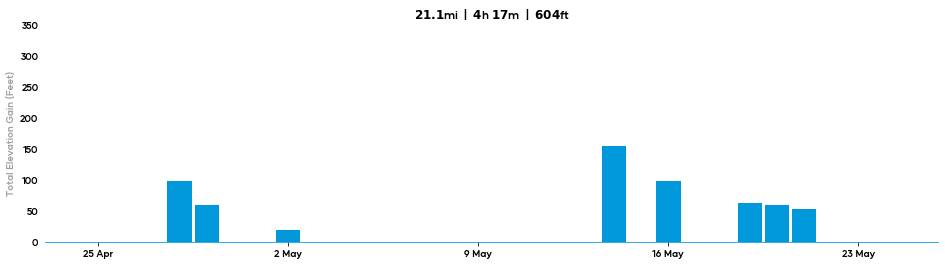

In [ ]:
#Resetting seaborn to prevent interference with matplotlib plots
sns.reset_orig()


# custom font
# https://stackoverflow.com/questions/35668219/how-to-set-up-a-custom-font-with-custom-path-to-matplotlib-global-font
# download the font and unzip (quiet so it does not print)
!wget -q 'https://dl.dafont.com/dl/?f=mustica_pro'
!unzip -qo "index.html?f=mustica_pro"

# move to directory where fonts should be kept
!mv MusticaPro-SemiBold.otf /usr/share/fonts/truetype/

# build cache, redirect to /dev/null to suppress stdout output
!fc-cache -f -v > /dev/null

import matplotlib as mpl
import matplotlib.font_manager as fm

# try and except, just in case something fails we fallback onto the
# default font
try:
    fe = fm.FontEntry(
        #font name
        fname='/usr/share/fonts/truetype/MusticaPro-SemiBold.otf',
        name='mustica-pro')
    fm.fontManager.ttflist.insert(0, fe) # or append is fine
    mpl.rcParams['font.family'] = fe.name # = 'your custom ttf font name'
except:
    pass

#Creating a matplotlib plot of size 16,4
plt1 = plt.figure(figsize=(16,4))
ax = plt1.gca()

#Plotting a bar chart with our data in the dictionary
plt.bar(date_etime.keys(),date_etime.values(),color="#0098DB", width=0.9)

#Adding the title to the chart
plt.title( "$\\bf{"+str(round(total_distance / 1609,1))+"}$mi  |  "+
          "$\\bf{"+str(round(total_time/3600))+"}$h "+"$\\bf{"+
          str(round(total_time%60))+"}$m  |  "
          +"$\\bf{"+str(round(total_elevation))+"}$ft")

#Only showing xticks for one day/week
ax.set_xticks(ax.get_xticks()[::7])

#Limiting the y-axis based on our reference chart
plt.ylim((0,350))
plt.ylabel("Total Elevation Gain (Feet)",color="#a1a1a1")

# Removing the spines on top, left and right
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)

ax.tick_params(left=False, bottom=True)

#Setting the bottom spine to be the same color as the reference chart
ax.spines['bottom'].set_color('#0098DB')
plt.show()

<i>Above is a plot we created ourselves!</i>

##4.2 Visualizing participant's Weekly Summary!

If our participant is curious about a more detailed breakdown of their runs, Strava would show you their weekly summary using the following chart: <br>
<img src="https://trailingclosure.com/content/images/2020/12/IMG_6409.jpg" height="300">
 <br>
Again, Let's try to recreate it using the data we have fetched from the Strava API<br><br>
<b>Note:</b> Weekly summary includes all the runs, walks and rides walks recorded by the participant.

Enter the dates for the start and end dates for this chart below! 

In [ ]:
#@title Set date range for the chart above

start = "2022-04-27" #@param {type:"date"}
end = "2022-05-04" #@param {type:"date"}

In [ ]:
#Function that converts data into a date time object
datefixer = lambda date: datetime.fromisoformat(date[0:10])

#Applying datefixer function to every column of df_strava_summary
df_strava_summary = df_strava.assign(date 
                                =df_strava.get('start_date').apply(datefixer))

#Dictionary to store the hourly frequency
date_etime = {}

#Starting date of our chart
start_date = date(int(start.split('-')[0]),
                  int(start.split('-')[1]),int(start.split('-')[2]))

#Ending date of our chart
end_date = date(int(end.split('-')[0]),
                int(end.split('-')[1]),int(end.split('-')[2]))

#Creating a list of dates between start and end date
dates = list(pd.date_range(start_date,end_date-timedelta(days=1),freq='d'))

Similar to 4.1, we will be storing all the data in the dictionary and plotting it!

In [ ]:
# Storing toal distance, time and elevation
total_distance = 0
total_time = 0
total_elevation = 0

for date_val in dates:
  date_etime[str(date_val.day)+" "+str(date_val.month_name())[:3]] = 0
  for actvity_index in range(len(df_strava_summary)):
    #Checks if the current date is in the activity DataFrame
      if(date_val == df_strava_summary.iloc[actvity_index].get('date')):

        #Storing total time, distance and elevation

        total_distance = (total_distance +
                          df_strava_summary.iloc[actvity_index].get('distance'))
        
        total_time = (total_time +
                      df_strava_summary.iloc[actvity_index].get('moving_time'))
        
        total_elevation = (total_elevation +
              df_strava_summary.iloc[actvity_index].get('total_elevation_gain'))
        
        #Stores the elevation of moving time in dictionary
        date_etime[str(date_val.day)+" "
        +str(date_val.month_name())[:3]] = (date_etime[str(date_val.day)
        +" "+str(date_val.month_name())[:3]] +
         df_strava_summary.iloc[actvity_index].get('moving_time')/60)

Now that we have all the data required, we can finally plot the chart we saw above!

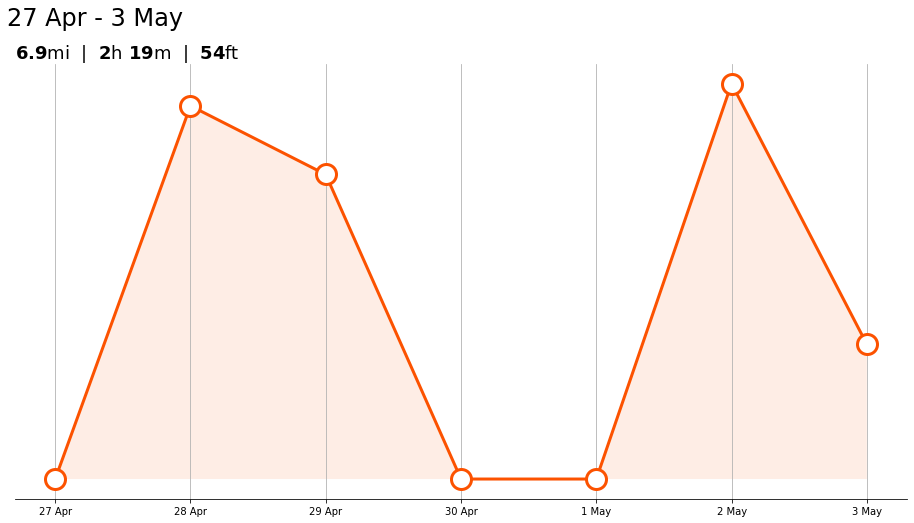

In [ ]:
#Resetting seaborn to prevent interference with matplotlib plots
sns.reset_orig()

# Creating a matplotlib plot of size 16,8
plt1 = plt.figure(figsize=(16,8))
ax = plt1.gca()


plt.plot(list(date_etime.keys()),list(date_etime.values()),color="#FC5200",
         marker='o', fillstyle='none', lw=3, markerfacecolor='white', ms=20, 
         mew=3, markeredgecolor='#FC5200')

plt.fill_between(list(date_etime.keys()),
                 list(date_etime.values()), facecolor='#FC5200',alpha=0.1)



# Adding veritcal grids
plt.grid(axis="x")

# Hiding the y-ticks
ax.axes.get_yaxis().set_visible(False)

#Adding the title to the chart
plt.suptitle(list(date_etime.keys())[0]+" - "+
             list(date_etime.keys())[-1],fontsize=24,x=0.195)
#Adding the subtitle to the chart
plt.title( "$\\bf{"+str(round(total_distance / 1609,1))+"}$mi  |  "+
          "$\\bf{"+str(round(total_time/3600))+"}$h "+"$\\bf{"+
          str(round(total_time%60))+"}$m  |  "+"$\\bf{"+
          str(round(total_elevation))+"}$ft",fontsize=18,loc='left')

# Removing the spines on top, left and right
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)

<i>Above is a plot we created ourselves!</i>

##4.3 Visualizing Participant's Runs!

Strava's website and app allows the user to visualize the routes for all their activities recorded synced on the Strava application. It is a very interesting feature as it lets the participants view the exact route they took during their activity on an actual map.

<img src="https://blog.strava.com/wp-content/uploads/2020/03/03-Save-Sync-Share.png"> <br>


Let's try to recreate the plots using the participant's data! <br> <br>
Here's a reference to how our overall result will look like

<img src="https://cf.veloviewer.com/img/veloviewer-strava-segments-homepage.png" width=700>

Interestingly, Strava provides us with this route data in the form of polylines. In the df_strava dataframe we can see a column called summary_polyline for all the individual activities. We will be using this column for our plot! <br>

Polyline is a encoded format that store coordinate location and it has to be decoded before it can be used. If we have a closer look into it, it is a bunch of characters that make no sense to an average reader.

In [ ]:
df_strava.get(['map.summary_polyline'])

,map.summary_polyline
0,
1,mnzrIuwlkABDIw@CCAVCCNZr@p@LFIDFFb@NVRGBs@QWk@...
2,urwrIkyriADxDGtB[zEM|@YrA{EdOgBzEaAvCoObg@cEjN...
3,gklcFdtshV@HIJMFO@u@Gs@SYA{@Oq@]]_@k@K_@S[KmAO...
4,mtlcFrqshVq@IKGIMEAqAW_@CgASSMiAWYIe@Im@WWQ]BY...
5,ailcF|lshVFKF]AEIG[AcAUi@G]Mg@?s@[i@Au@Ye@W_@M...
6,ovlcFhrshVy@GmAWa@CUIQMQUGS?GTm@D[J]Fk@JUBQ?]I...
7,wilcFltshVCEGCYFW@e@QSAU@GAQG]EgBg@q@Kc@BW?m@G...
8,aflcFpzshVALPz@Rb@DFD@hAo@N@HCt@y@HGHAPBPHPh@J...
9,


However, we can use a decode function to convert this sequence of characters into something meaningful. Here's an example of how the decoded summary forms the coordinates.

In [ ]:
# [:10] limits the number of coordinates to just the first 10
fixed_df = df_strava.iloc[0].get(['map.summary_polyline']).apply(
    polyline.decode)
fixed_df['map.summary_polyline'][:10]

[]

Interestingly, the gibbeish above turns into coordinate points after decoding!

Next we will save the coordinates of the first map and find its centroid to center our map. If we don't do this, our map would not be able to focus on the set of coordinates that we have!
<br><br>
<b>Note:</b> We will be using a library called folium to display an interactive map and plotting our polylines above it.

In [ ]:
#Dictionary to save the coordinates of the first ride
my_ride = df_strava.iloc[1].get(['map.summary_polyline']).apply(polyline.decode)['map.summary_polyline']

In [ ]:
#Select one activity to find the centroid of the map.
centroid = [
    np.mean([coord[0] for coord in my_ride]), 
    np.mean([coord[1] for coord in my_ride])
  ]

#Creating a map 
m = folium.Map(location=centroid, zoom_start=13)

# Plot all rides on map
for i in range(len(df_strava)):
  if len(df_strava.iloc[i].get(
      ['map.summary_polyline'])['map.summary_polyline']) == 0:
    continue

  # Polyline.decode is a function that helps us decode this polyline data to coordinates
  my_ride = df_strava.iloc[i].get(['map.summary_polyline']).apply(
      polyline.decode)['map.summary_polyline']

  # We plot the route on the map.
  print(my_ride)
  folium.PolyLine(my_ride, color='red').add_to(m)
display(m)

[(55.68247, 12.52235), (55.68245, 12.52232), (55.6825, 12.5226), (55.68252, 12.52262), (55.68253, 12.5225), (55.68255, 12.52252), (55.68247, 12.52238), (55.68221, 12.52213), (55.68214, 12.52209), (55.68219, 12.52206), (55.68215, 12.52202), (55.68197, 12.52194), (55.68185, 12.52184), (55.68189, 12.52182), (55.68215, 12.52191), (55.68227, 12.52213), (55.68228, 12.52209), (55.68227, 12.52201), (55.68229, 12.52202), (55.68234, 12.52199), (55.68231, 12.52191), (55.68229, 12.52193), (55.68225, 12.52187)]
[(55.66779, 12.22566), (55.66776, 12.22473), (55.6678, 12.22414), (55.66794, 12.22304), (55.66801, 12.22273), (55.66814, 12.22231), (55.66924, 12.21972), (55.66976, 12.21862), (55.67009, 12.21786), (55.67273, 12.21144), (55.67371, 12.20898), (55.67397, 12.20837), (55.674, 12.20833), (55.67405, 12.20832), (55.67411, 12.20838), (55.67458, 12.20933), (55.67533, 12.21116), (55.67563, 12.21199), (55.67575, 12.21236), (55.67589, 12.21309), (55.67611, 12.21479), (55.67616, 12.21577), (55.67631, 12.

<i>Above is an interactive map that we plotted ourselves</i>

#5. Data Analysis

Now that we have found, the weekly summary for the participant's activity time, let's plot some graphs to see if there is a correlation between the various metrics of the participants data.

First let's replot our original dataframe to see what all parameters we have access to.

In [ ]:
df_strava

In order to focus on the just the runs, we will have to clean the dataframe and only keep activities of the type 'Run'.

In [ ]:
# This will help us restrict our dataset to only the activities which are classified as 'Run'
df_runs = df_strava[df_strava.get('type')=='Run']

Additionally, there are a lot of NaN values in our dataset that are incomplete to assist in our analysis. Let's remove them below!

In [ ]:
# We will drop the null values and only get the columns we need
df_runs_cleaned = df_runs.get(['max_speed','max_heartrate']).dropna()

As the strava api returns the max_speed values in meters/second and our above plots use miles, we will convert max speed to km/hour to maintain consistency.

In [ ]:
df_runs_cleaned = df_runs_cleaned.assign(max_speed =
                    df_runs_cleaned.get('max_speed').apply(lambda x: x*3.6))

Let's plot the cleaned Data Frame below!

In [ ]:
df_runs_cleaned

## 5.1 Heart Rate vs. Max Speed
Maybe the heart rate is correlated with how fast you run. Let's test if this hypothesis is true. We will do so by plotting a scatterplot between those two metrics and finding the correlation.

First, we will plot a chart to see if there is a visual correlation between a partcipant's max heart rate and their max speed.

In [ ]:
# Setting Figure Size in Seaborn
sns.set(rc={'figure.figsize':(16,8)})

# Setting Seaborn plot style
sns.set_style("darkgrid")

#Plotting our data
plot = sns.regplot(data=df_runs_cleaned, x="max_speed", y="max_heartrate")

#Renaming x and y labels
plot.set_ylabel("Maximum Heart Rate (bpm)", fontsize = 16)
plot.set_xlabel("Maximum Speed (km/hr)", fontsize = 16)


As we can see from the scatterplot above, our regression line hints that there might be a correlation between maximum speed and maximum heart rate. Let's compute $R^2$ just to see exactly how correlated.

We'll follow [this documentation](https://docs.scipy.org/doc/scipy-0.15.1/reference/generated/scipy.stats.linregress.html) and perform a linear regression to obtain the coefficient of determination.

In [ ]:
from scipy import stats

slope, intercept, r_value, p_value, std_err = stats.linregress(
    df_runs_cleaned.get('max_speed'), df_runs_cleaned.get('max_heartrate'))

print(f'Slope: {slope:.3g}')
print(f'Coefficient of determination: {r_value**2:.3g}')
print(f'p-value: {p_value:.3g}')

As we can see that the p-value is slightly over 5% which means that there is not enough evidence to convincingly conclude that that there is a correlation between heart rate and speed. However, our p-value is very close to the 5% mark. Let's try to locate the outliers in this data and find points that might be skewing our dataset and preventing us from gathering enough evidence to prove our correlation.

##5.2 Outlier Detection

Before finding the individual outlier values, it would be interesting to see the summary of our max_speed and max_heartrate parameters. It will give us a clear idea of what values are typical and which values can be considered atypical based on the data that we recieved from Strava.

In [ ]:
df_runs_cleaned_summary = df_runs_cleaned.describe().get(
    ['max_speed','max_heartrate'])
df_runs_cleaned_summary

To locate the outliers we will be using a supervised as well as unsupervised algorithm called the Elliptic Envelope. In statistical studies, Elliptic Envelope created an imaginary elliptical area around a given dataset where values inside that imaginary area is considered to be normal data, and anything else is assumed to be outliers. It assumes that the given Data follows a gaussian distribution.

"The main idea is to define the shape of the data and anomalies are those observations that lie far outside the shape. First a robust estimate of covariance of data is fitted into an ellipse around the central mode. Then, the Mahalanobis distance that is obtained from this estimate is used to define the threshold for determining outliers or anomalies." [(S. Shriram and E. Sivasankar ,2019, pp. 221-225)](https://ieeexplore.ieee.org/document/9004325)

In [ ]:
#create the model, set the contamination as 0.02
EE_model = EllipticEnvelope(contamination = 0.02)

#implement the model on the data
outliers = EE_model.fit_predict(df_runs_cleaned[["max_speed", "max_heartrate"]])

#extract the labels
df_runs_cleaned["outlier"] = outliers

#change the labels
# We use -1 to mark an outlier and +1 for an inliner
df_runs_cleaned["outlier"] = df_runs_cleaned["outlier"].apply(
    lambda x: str(-1) if x == -1 else str(1))

#extract the score
df_runs_cleaned["EE_scores"] = EE_model.score_samples(
    df_runs_cleaned[["max_speed", "max_heartrate"]])

#print the value counts for inlier and outliers
print(df_runs_cleaned["outlier"].value_counts())

Below we will replot the df_runs_cleaned dataframe to see how the two new columns were applied to it!

In [ ]:
df_runs_cleaned

Now that we have labeled the outliers as -1, let's try to see which values of max heartrate and max speed are being considered as outliers by our Elliptic Envelope Algorithm.

In [ ]:
outlier_df = df_runs_cleaned[df_runs_cleaned.get('outlier')=='-1'].get(
    ['max_heartrate','max_speed'])
outlier_df

Using the dataframe above, we can highlight these outlier values in our original scatterplot in order to visually asses which pair/s of max speed and max heart rate values are not following the general trend seen in our scatterplot.

In [ ]:
df_runs_cleaned.drop(outlier_df.index)

In [ ]:
# Setting Figure Size in Seaborn
sns.set(rc={'figure.figsize':(16,8)})

# Setting Seaborn plot style
sns.set_style("darkgrid")

# Plotting our data
# We will calculate the regression line while not accounting for our outliers
plot = sns.regplot(data=df_runs_cleaned.drop(outlier_df.index), x="max_speed",
                   y="max_heartrate")

#Renaming x and y labels
plot.set_ylabel("Maximum Heart Rate (bpm)", fontsize = 16)
plot.set_xlabel("Maximum Speed (km/hr)", fontsize = 16)

# Plotting the outlier and highlighting it
plt.scatter(outlier_df.get('max_speed'),outlier_df.get('max_heartrate'))
plt.scatter(outlier_df.get('max_speed'),outlier_df.get('max_heartrate'),
            facecolors='red',alpha=.35, s=500)

Thus, the points highlighted in red are ones that seem to not be following the general trend of our dataset. Lastly, let's see what the new p-value is after outlier removal!

In [ ]:
slope, intercept, r_value, p_value, std_err = stats.linregress(
    df_runs_cleaned.drop(outlier_df.index).get('max_speed'), 
    df_runs_cleaned.drop(outlier_df.index).get('max_heartrate'))

print(f'Slope: {slope:.3g}')
print(f'Coefficient of determination: {r_value**2:.3g}')
print(f'p-value: {p_value:.3g}')

Our new p-value after removing any outliers is 1.2% which is less than  5%. Therefore, after removing the outliers, our result is statistically significant which means that there is enough evidence to conclude that that there is a correlation between maximum speed and the maximum heart rate.